In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')

import transformer_lens
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute, _plot_attn, tokenize_plus
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer

In [4]:
cache_dir = '/home/xd/.cache/torch/transformers/'
model_name = 'lmsys/vicuna-33b-v1.3'
proxies = {'http': '192.168.53.250:10801'}
device = 0
model0 = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
    local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False, load_in_4bit=True, bnb_4bit_quant_type='nf4')
# model0 = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
#     local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In PreTrainedModel.from_pretrained: resolved_archive_file, filename = /home/xd/.cache/torch/transformers/132115a70169b8c5fbf5bf7aef5f9d6823f3853d163474fba15145c3d7460bcc.7f36ca25942bd037786a5dcc90e9a9659aa140a20766b90f2cbe4d623e54e261 pytorch_model.bin


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
model = HookedTransformer.from_pretrained("llama-30b-hf",center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    fold_value_biases=False,
    device='cuda',
    hf_model=model0,
    tokenizer=tokenizer,
    hf_model_4bit=True,
    dtype="float16",
)

Loaded pretrained model llama-30b-hf into HookedTransformer


In [78]:
tokenizer.convert_ids_to_tokens([28639])

['▁weapon']

In [7]:
for word in ['animal','sport','clothes','fruit','food','weapon','vehicle','instrument','drink','insect']:
    print(tokenizer.encode(word, add_special_tokens=False))

[13019]
[7980]
[22095]
[15774]
[9687]
[28639]
[19716]
[11395]
[13748]
[17564]


In [7]:
# task = 'c_task'
task = 'g_task'
# task = 'ioi'

In [8]:
model.cfg.use_split_qkv_input = False
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True
task_metric_name = 'logit_diff'  # -> 'prob_diff'
ds = EAPDataset(task, model_name, filename="g_task_16_1.csv")
# ds = EAPDataset(task, model_name, filename="c_task_32_1.csv")
# ds = EAPDataset(task, model_name)
batch_size = 1
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

In [9]:
model_name_noslash = model_name.split('/')[-1]

import time
T1 = time.time()
g = Graph.from_model(model)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

运行时间：60.5423378944397 s


In [10]:
T1 = time.time()
attribute(model, g, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)
T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 14743891/14743891 [00:13<00:00, 1119594.40it/s]

运行时间：140.71426510810852 s


In [13]:
g.apply_greedy(100, absolute=False)
# g.prune_dead_nodes()
gs = g.to_graphviz()
gs.draw(f'vicuna-33b_4bit-g-split_qkv_false2.png', prog='dot')

In [14]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

100%|██████████| 16/16 [00:00<00:00, 2352.22it/s]


In [21]:
layer, head = [(29, 0), (25, 12), (22, 35), (27, 35)][0]

In [27]:
layer, head = [(19, 24), (20, 50), (19, 28)][2]

In [37]:
layer, head = [(13, 24), (15, 25), (18, 38), (18, 35)][3]

IndexError: list index out of range

In [44]:
layer, head = [(15, 47), (15, 0)][0]

In [42]:
layer, head = [(11, 36)][0]

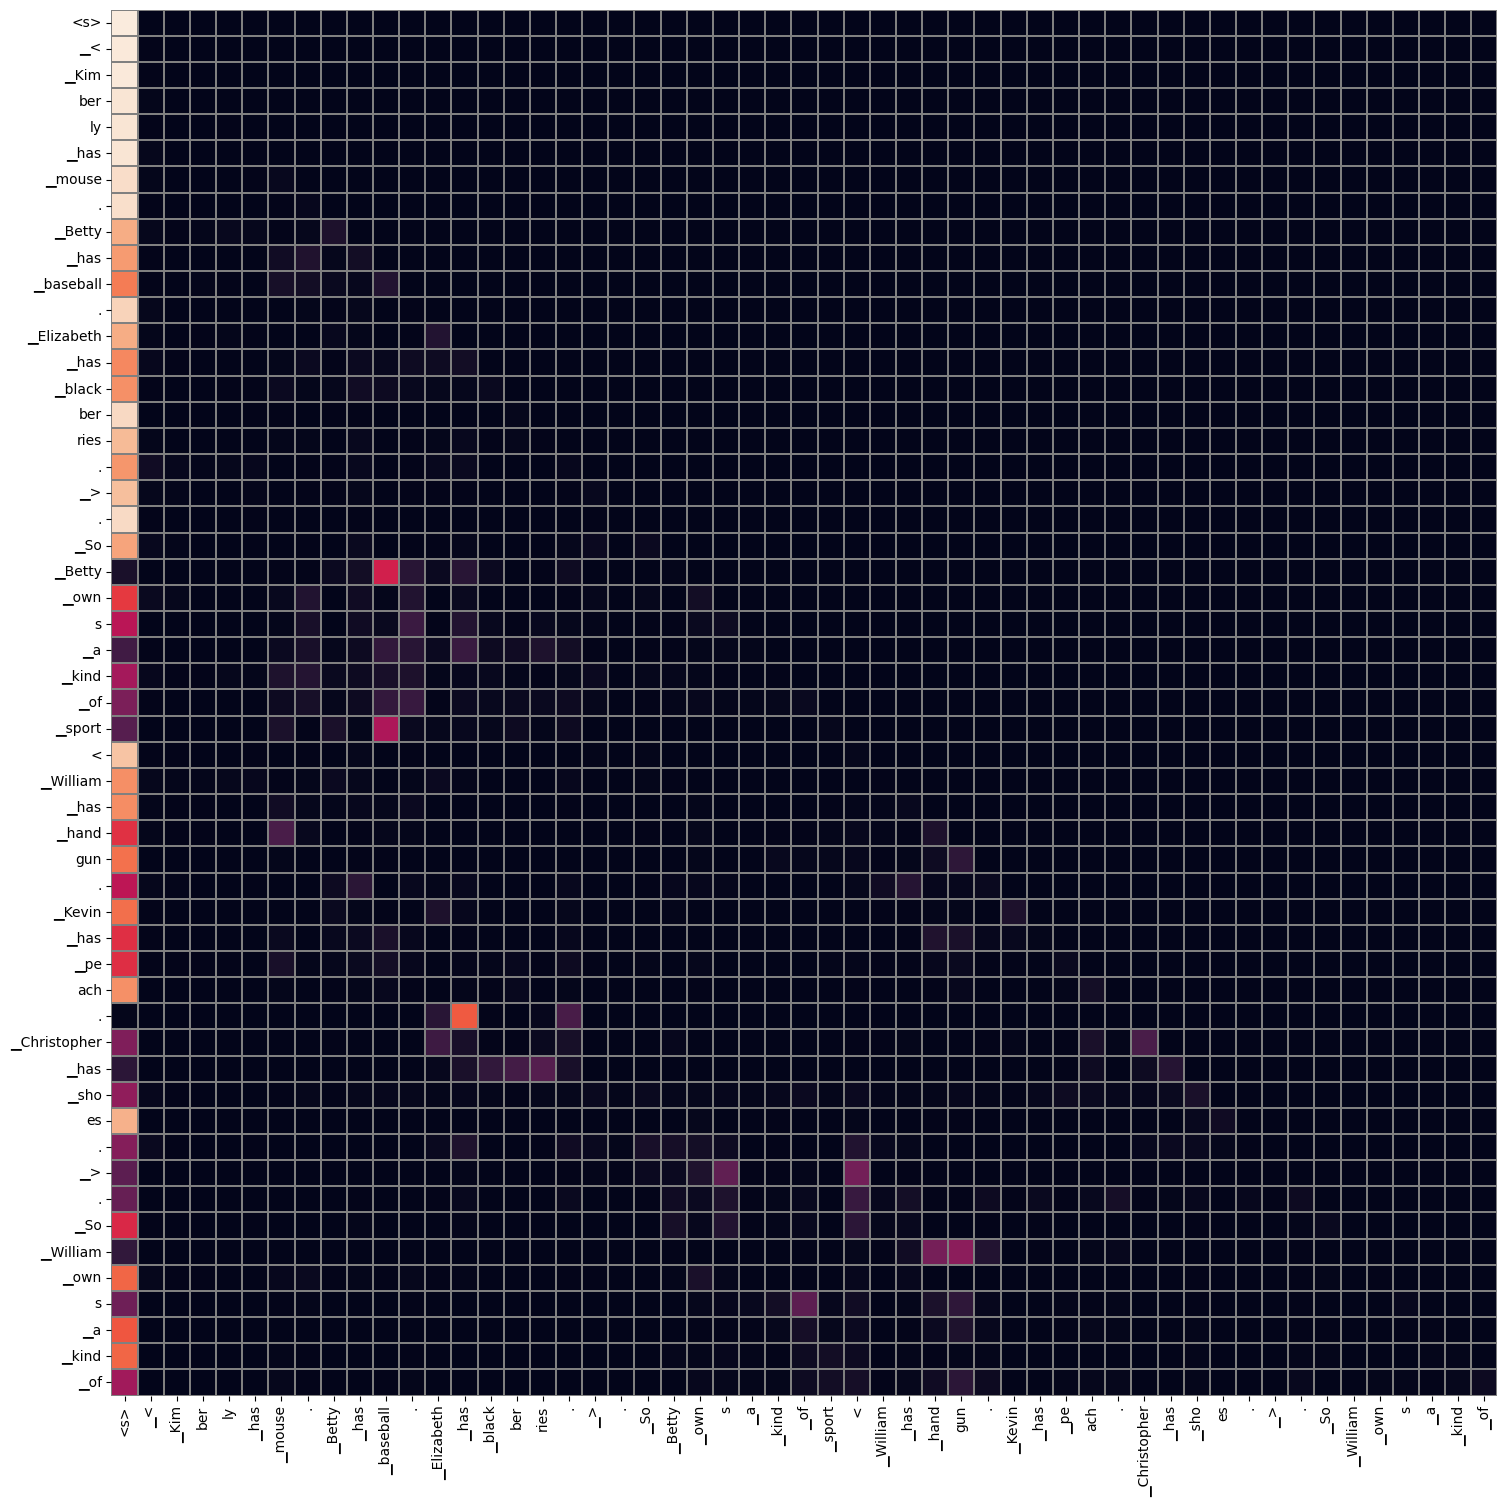

In [45]:
from eap.attribute import tokenize_plus
for clean, corrupted, label in dataloader[0:1]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask= attention_mask)
    tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
    attn = cache[f'blocks.{layer}.attn.hook_pattern'][0][head]
    _plot_attn(attn, tokens, figsize=(18, 18))